In [21]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow

genes = ["CTNNB1", "JUND", "CD320", "IFI6"]
levels = ["0", "0.5", "1.0"]
data_dir = "/data/scgpt_perturbation_colon_epithel2/perturbations"
file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
base_fname = file_pattern.format(gene = "JUND", level = "1.0")
base_embeddings = np.load(f"{base_fname}.embeddings.npy")
adata = anndata.read_h5ad(f"{base_fname}.h5ad")
base_df = adata.obs[["tissue", "cell_type", "disease"]].copy()
with open("xgboost_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)
base_df.sample(5)

,tissue,cell_type,disease
cell_id,,,
N18_Epi_A-TAGATTGATTCTCA,transverse colon,stem cell,normal
N46_Epi_A-TGATTTCTCGTTTAGG,right colon,enterocyte,normal
N18_Epi_A-AGAACGCTATTCTC,transverse colon,enterocyte,normal
N114902_N-TCAACGAGTTCACCTC,colon,enterocyte,Crohn disease
N110204_E-AAGCATCCACACAGCC,colonic epithelium,enterocyte,Crohn disease


In [22]:
base_df["disease_probability_base"] = xgb_model.predict_proba(base_embeddings)[:,0]
base_df.sample(10, random_state=10)


,tissue,cell_type,disease,disease_probability_base
cell_id,,,,
N15_Epi_B-TTTCCAGATGCCCT,right colon,enterocyte,normal,0.085437
N16_Epi_A-TTGAACCTGGGTGA,right colon,goblet cell,normal,0.265644
N114902_N-AGCGGTCAGGGTGTGT,colon,enterocyte,Crohn disease,0.809372
H106265_N-GGGTCTGCAAGGCTCC,colon,enteroendocrine cell,normal,0.222370
N130084_E-TACTGCCAGGCTGGAT,colonic epithelium,enterocyte,Crohn disease,0.995563
N104689_N2-TCTGAGACAACGCACC,right colon,enterocyte,Crohn disease,0.838990
H197396_N1-TACGGGCAGGGTTTCT,colon,enterocyte,normal,0.150394
N17_Epi_A-GACGTATGAGGGTG,transverse colon,epithelial cell,normal,0.048334
I175041_N2-AGTGGGAAGGATTCGG,sigmoid colon,goblet cell,Crohn disease,0.999276


In [26]:
# now lets ask: how the probability of the disease changes based on the embeddings + xgboost ?

gene = "JUND"
KO_embeddings = np.load(file_pattern.format(gene = gene, level = "0") + ".embeddings.npy")
OE_embeddings = np.load(file_pattern.format(gene = gene, level = "5.0") + ".embeddings.npy")
df = []
for emb in [KO_embeddings, OE_embeddings]:
    df_ = base_df.copy()
    df_["expression_level"] = "KO" if emb is KO_embeddings else "OE"
    df_["disease_probability"] = xgb_model.predict_proba(emb)[:,0]
    df += [df_]
df = pd.concat(df)
df["disease_proba_change"] = df["disease_probability"] - df["disease_probability_base"]
df.sample(5, random_state=10)

,tissue,cell_type,disease,disease_probability_base,expression_level,disease_probability,disease_proba_change
cell_id,,,,,,,
N128624_E-GCTTGGGTCCACATAG,colonic epithelium,enterocyte,Crohn disease,0.990795,KO,0.990795,0.0
N130084_E-TTCAATCTCTCACGAA,colonic epithelium,enterocyte,Crohn disease,0.582662,OE,0.582662,0.0
H197396_N1-TTCGAAGAGACAGACC,colon,enterocyte,normal,0.116086,KO,0.116086,0.0
N21_Epi_A-CTATTGACCCTCCA,left colon,enterocyte,normal,0.001659,OE,0.001659,0.0
H197396_N1-ACTGTCCTCCAGGGCT,colon,enterocyte,normal,0.493592,KO,0.493592,0.0


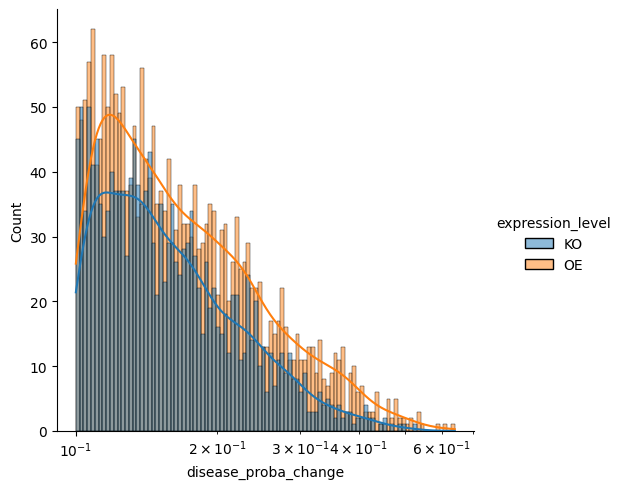

In [34]:
sns.displot(
    data=df.query("abs(disease_proba_change) > 0.1"),
    x="disease_proba_change",
    kde=True,
    bins=100,
    hue="expression_level",
    log_scale=True,
)


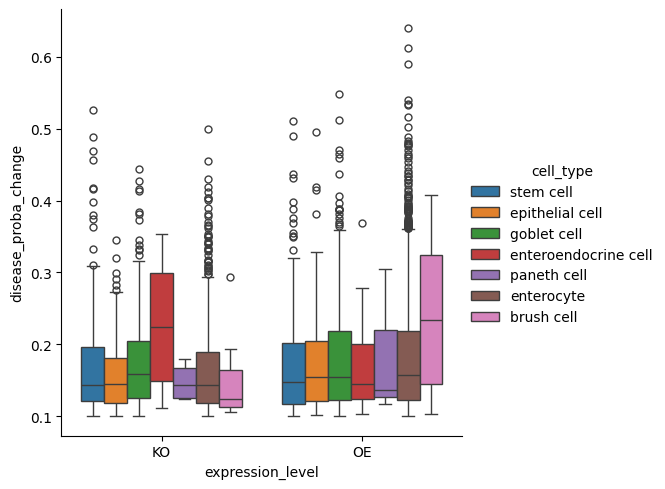

In [39]:
sns.catplot(data=df.query("disease_proba_change > 0.1"), hue="cell_type", x="expression_level", y="disease_proba_change", kind="box")

In [40]:
# what characterizes cells that scGPT 'thinks' are more likely to be diseased after the perturbation?

In [56]:
change_level = 0.1
expression_level = 'KO'
df_change = df.query(f"abs(disease_proba_change) > {change_level} and expression_level == '{expression_level}'")
df_change.shape[0]

print(f"number of genes with probability change of over {change_level*100}% is {df_change.shape[0]}")
print(f"which is {df_change.shape[0] / base_df.shape[0] * 100:.2f}% of the total")

number of genes with probability change of over 10.0% is 3728
which is 3.81% of the total


In [67]:
cell_type_dist = (
    base_df.groupby("cell_type", observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count_total"})
)
(
    df_change.groupby(["expression_level", "cell_type"], observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .merge(cell_type_dist, on="cell_type")
    .eval("fraction_percentage = (count / count_total) * 100")
)


,expression_level,cell_type,count,count_total,fraction_percentage
0,KO,stem cell,767,18499,4.146170
1,KO,epithelial cell,275,8187,3.358984
2,KO,goblet cell,672,15650,4.293930
3,KO,enteroendocrine cell,29,549,5.282332
4,KO,paneth cell,6,311,1.929260
5,KO,enterocyte,1949,53398,3.649949
6,KO,brush cell,30,1194,2.512563


In [94]:
gb = "tissue"

_dist = (
    base_df.groupby(gb, observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count_total"})
)

(
    df_change.groupby(["expression_level", gb], observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .merge(_dist, on=gb)
    .eval("fraction_percentage = (count / count_total) * 100")
)

,expression_level,tissue,count,count_total,fraction_percentage
0,KO,colonic epithelium,874,17553,4.979206
1,KO,caecum,141,2493,5.655836
2,KO,colon,1218,27758,4.387924
3,KO,transverse colon,82,4402,1.862790
4,KO,sigmoid colon,28,5385,0.519963
5,KO,caecum epithelium,104,1300,8.000000
6,KO,lamina propria of mucosa of colon,271,8076,3.355622
7,KO,left colon,453,9951,4.552306
8,KO,right colon,557,20870,2.668903


In [95]:
gb = ["tissue","cell_type"]

_dist = (
    base_df.groupby(gb, observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count_total"})
)

(
    df_change.groupby(["expression_level", *gb], observed=False)
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .merge(_dist, on=gb)
    .eval("fraction_percentage = (count / count_total) * 100")
    .sort_values("fraction_percentage", ascending=False)
    .dropna()
    .pivot(index="tissue", columns="cell_type", values="fraction_percentage")
    .fillna(0)
    .style
    .background_gradient(cmap="Blues")
    .format("{:.1f}%")
)

cell_type,stem cell,epithelial cell,goblet cell,enteroendocrine cell,paneth cell,enterocyte,brush cell
tissue,,,,,,,
colonic epithelium,7.3%,4.8%,2.9%,3.1%,6.2%,5.0%,2.5%
caecum,5.6%,3.1%,9.6%,28.6%,0.0%,5.3%,0.0%
colon,3.6%,3.7%,5.8%,7.9%,3.0%,4.4%,3.4%
transverse colon,1.6%,2.8%,2.0%,18.8%,0.0%,1.7%,0.0%
sigmoid colon,0.7%,0.2%,0.4%,3.8%,0.0%,0.4%,3.6%
caecum epithelium,14.0%,11.3%,1.8%,0.0%,0.0%,8.2%,1.4%
lamina propria of mucosa of colon,6.8%,3.0%,2.1%,3.7%,1.6%,2.9%,1.3%
left colon,4.0%,5.9%,6.7%,2.0%,0.0%,3.9%,4.0%
right colon,2.8%,1.9%,4.0%,1.9%,0.0%,2.4%,2.6%


<97788x1800 sparse matrix of type '<class 'numpy.float32'>'
	with 10202645 stored elements in Compressed Sparse Row format>